22.4583269846107


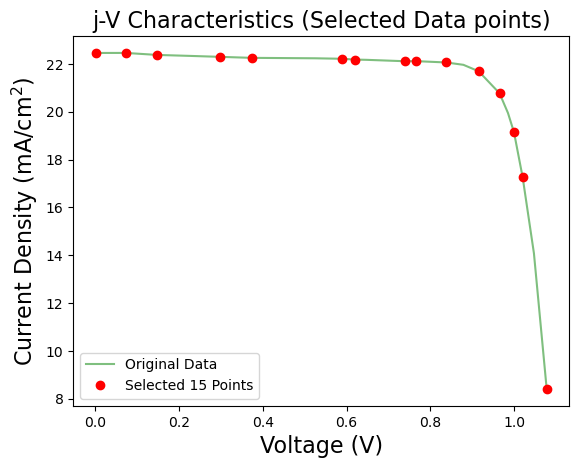

0.00129705174758296 22.45756513789425
0.0725392627127509 22.45756513789425
0.147600902556746 22.3746762151455
0.298238221186175 22.2939204632028
0.373263997848209 22.2523236324851
0.588496884386067 22.2140789273198
0.61981739663185 22.1807100411397
0.739917215821641 22.11260094468995
0.765314325846894 22.11260094468995
0.837925314923567 22.0589669358525
0.915055064927303 21.6914520798415
0.964910865049835 20.772055462441
0.999447109278104 19.1409416425415
1.02011027928453 17.2582660368734
1.07746148443687 8.40789273198233


In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.isotonic import IsotonicRegression

data = pd.read_excel('CdTe.xlsx')
vd = data['V'].to_numpy()
jd = data['J'].to_numpy()
jph=np.max(jd)
print(jph)

ir = IsotonicRegression(increasing=False)
jd_s = ir.fit_transform(vd, jd)  # Fit and transform
vd_s = vd  # Keep voltage values the same

num_points = 15
indices = np.linspace(0, len(vd_s) - 1, num=num_points, dtype=int)
vd_s = vd_s[indices]
jd_s = jd_s[indices]

plt.plot(vd, jd, color='green', alpha=0.5, label='Original Data')
plt.plot(vd_s, jd_s, 'o', label='Selected 15 Points', color='red')
plt.xlabel('Voltage (V)', fontsize='16')
plt.ylabel('Current Density (mA/cm$^2$)', fontsize='16')
plt.title('j-V Characteristics (Selected Data points)', fontsize='16')
plt.legend()
plt.show()

for i in range(len(vd_s)):
    print(vd_s[i], jd_s[i])

22.458500690610553
Rsh (ohm-cm^2) = 2046.5694359057434
Rs (ohm-cm^2)= 4.327017382420579
m = 3.5969252483784593
j0 (mA/cm^2)= 0.00017370599985255808


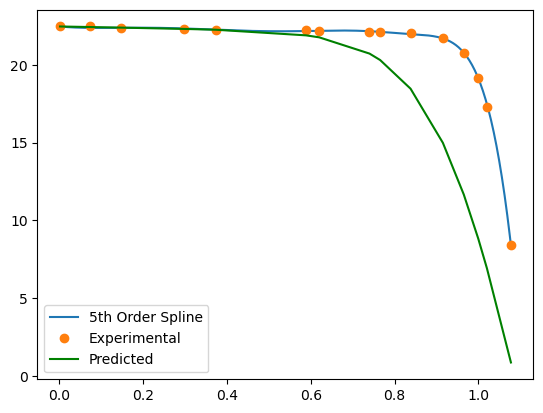

In [96]:
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.optimize import fsolve

k=2
v=vd_s[::k]
j=jd_s[::k]
m=len(v)-1

def diode_eq(jp, vd, j0, jph, Rs, Rsh, m):
    return jph - j0*(np.exp(q*(vd+jp*Rs)/(m*k*T)) - 1)-vd/Rsh-jp

qs = InterpolatedUnivariateSpline(v, j, k=5)
v_fine=np.linspace(min(v), max(v), 500)
j_fine=qs(v_fine)

#Fitting Cubic Polynomial
j_d_prime = qs.derivative(1)(v_fine)
j_d_double_prime = qs.derivative(2)(v_fine)
cubic_coeffs = np.polyfit(j_d_prime, j_d_double_prime, 3)
roots = np.roots(cubic_coeffs)
roots = np.sort(roots)

Rsh=-1 / np.real(roots[-1])
Rs=-1/np.mean(np.real(roots[:-1]))
ca3=cubic_coeffs[0]
f=ca3/Rs**2
g=f*Rs
b=-1/Rsh

numerator=j_d_prime-b
denominator=f+g*j_d_prime
dep_var=numerator/denominator
indep_var=j_fine-b*v_fine
a=-1*(dep_var-indep_var)
asort=np.sort(a)
jph=22.4583269846107

for i in range(len(asort)):
    if(asort[i]>jph):
        print(asort[i])
        j0=asort[i]-jph
        break

m=38.91/f

q = 1.602e-19
k = 1.3806e-23
T = 298

#Rsh=10
jp = np.array([fsolve(diode_eq, jph, args=(v, j0, jph, Rs, Rsh, m))[0] for v in vd_s])

print("Rsh (ohm-cm^2) =", Rsh*1000)
print("Rs (ohm-cm^2)=", Rs*1000)
print("m =", m)
print("j0 (mA/cm^2)=", j0)

plt.plot(v_fine, j_fine, label='5th Order Spline')
plt.plot(vd_s, jd_s, 'o', label='Experimental')
plt.plot(vd_s, jp, color='green', label='Predicted')
plt.legend()
plt.show()

j0= 4.363297441014461e-05


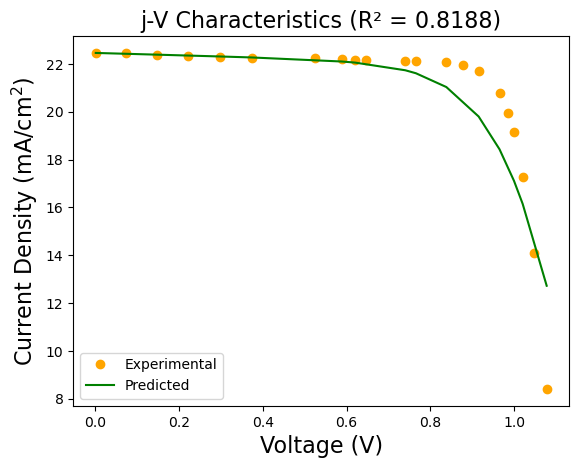

In [98]:
q = 1.602e-19
k = 1.3806e-23
T = 298

a=2
j0=1.7370599985255808*10**(-1*a)
r2=-100
af=2
#print(jph, Rs, Rsh)
for i in range(100):
    a=a+0.1
    j0=1.7370599985255808*10**(-1*a)
    jp = np.array([fsolve(diode_eq, jph, args=(v, j0, jph, Rs, Rsh, m))[0] for v in vd_s])
    ss_res = np.sum((jd_s-jp) ** 2)
    ss_tot = np.sum((jd_s-np.mean(jd_s)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    #print(r_squared, a)
    if(r_squared>r2):
        af=a
        r2=r_squared
j0=1.7370599985255808*10**(-1*af-0)
jp = np.array([fsolve(diode_eq, jph, args=(v, j0, jph, Rs, Rsh, m))[0] for v in vd_s])
print("j0=", j0)
plt.plot(vd, jd, 'o', label='Experimental', color='orange')
plt.plot(vd_s, jp, color='green', label='Predicted')
plt.xlabel('Voltage (V)', fontsize='16')
plt.ylabel('Current Density (mA/cm$^2$)', fontsize='16')
plt.title(f"j-V Characteristics (R² = {r2:.4f})", fontsize='16')
plt.legend()
plt.show()

[43.63297441014461, 0.004327017382420579, 2.0465694359057434, 3.5969252483784593]
15 15
Iteration 0: R² = 0.86221
[4.77432451e+01 3.95261016e-03 2.04822489e+00 3.60686851e+00]
15 15
Iteration 1: R² = 0.86615
[5.15201057e+01 3.59899041e-03 2.04813871e+00 3.61340257e+00]
15 15
Iteration 2: R² = 0.87006
[5.48507228e+01 3.26640642e-03 2.04645434e+00 3.61664310e+00]
15 15
Iteration 3: R² = 0.87395
[5.76386644e+01 2.95486613e-03 2.04332156e+00 3.61672238e+00]
15 15
Iteration 4: R² = 0.87780
[5.98088859e+01 2.66416498e-03 2.03889353e+00 3.61378604e+00]
15 15
Iteration 5: R² = 0.88160
[6.13109905e+01 2.39391643e-03 2.03332393e+00 3.60798978e+00]
15 15
Iteration 6: R² = 0.88536
[6.21206210e+01 2.14358310e-03 2.02676440e+00 3.59949637e+00]
15 15
Iteration 7: R² = 0.88905
[6.22390470e+01 1.91250735e-03 2.01936239e+00 3.58847275e+00]
15 15
Iteration 8: R² = 0.89268
[6.16911809e+01 1.69994004e-03 2.01125925e+00 3.57508757e+00]
15 15
Iteration 9: R² = 0.89621
[6.05223712e+01 1.50506674e-03 2.0025888

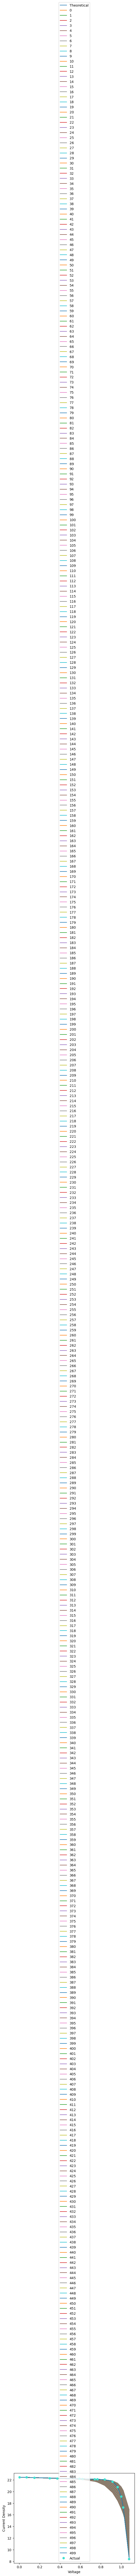

In [100]:
#Jacobian Correction
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import fsolve

def diode_eq(jp, vd, j0, jph, Rs, Rsh, m):
    return jph - j0*(np.exp(q*(vd+jp*Rs)/(m*k*T)) - 1)-vd/Rsh-jp

def Jmat(jp, vd, k1, Rs, Rsh, m):
    J=[0, 0, 0, 0]
    print(jp.size, vd.size)
    J[0]=-10**(-6)*(np.exp(q/(m*k*T)*(vd+Rs*jp))-1)
    J[1]=-k1*10**(-6)*np.exp(q/(m*k*T)*(vd+Rs*jp))*(q*jp/(m*k*T))
    J[2]=vd/(Rsh**2)
    J[3]=k1*10**(-6)*np.exp(q/(m*k*T)*(vd+Rs*jp))*(q/(m*m*k*T)*(vd+Rs*jp))
    return J

#The initial Values
k1=43.63297441014461
Rs=0.004327017382420579
Rsh=2.0465694359057434
m=3.5969252483784593

#Residual Computation
jp=np.array([fsolve(diode_eq, jph, args=(v, j0, jph, Rs, Rsh, m))[0] for v in vd_s])
R=jd_s-jp
P=[k1, Rs, Rsh, m]
plt.plot(vd_s, jp, label='Theoretical')
for i in range(500):
    print(P)
    J=Jmat(jp, vd_s, k1, Rs, Rsh, m)
    J1=np.dot(J, np.transpose(J))
    delP=-1*np.dot(np.linalg.inv(J1), np.dot(J, R))
    alpha=0.0185
    P=P-alpha*delP
    k1=P[0]
    Rs=P[1]
    Rsh=P[2]
    m=P[3]
    j0=k1*10**(-6)
    jp = np.array([fsolve(diode_eq, jph, args=(v, j0, jph, Rs, Rsh, m))[0] for v in vd_s])
    plt.plot(vd_s, jp, label=i)
    R=jd_s-jp
    R2 = 1 - np.sum(R**2) / np.sum((jd - np.mean(jd))**2)
    print(f"Iteration {i}: R² = {R2:.5f}")
print("j0=", j0)
print("Rs=", Rs)
print("Rsh=", Rsh)
print("m=", m)
plt.plot(vd_s, jd_s, 'o', label='Actual', color='turquoise')
#plt.plot(vd, jp, label='Theoretical')
plt.xlabel('Voltage')
plt.ylabel('Current Density')
plt.legend()
plt.show()

22.4583269846107


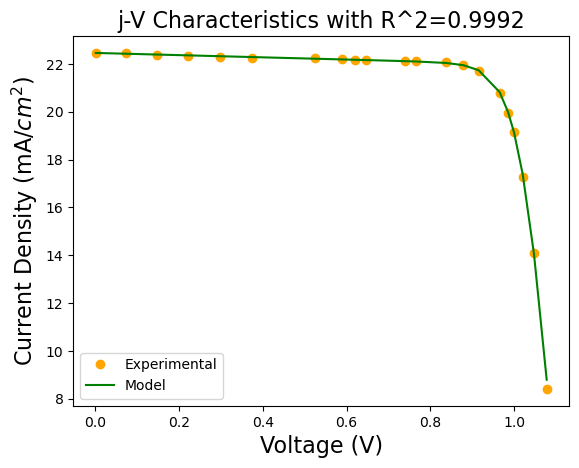

R$^2$: 0.9992582210760658


In [101]:
#Final Plot using Parameters Obtained
import numpy as np
import pandas as pd
from scipy.optimize import fsolve
from matplotlib import pyplot as plt

def diode_eq(jp, vd, j0, jph, Rs, Rsh, m):
    return jph - j0*(np.exp(q*(vd+jp*Rs)/(m*k*T)) - 1)-vd/Rsh-jp

#Knowns:
q=1.6*10**(-19)
k=1.38*10**(-23)
T=298

#Parameters Obtained
j0=2.347028409814693e-13
Rs=0.002415441305563168
Rsh=2.164013136274981
m=1.3502602377326958

print(jph)
data=pd.read_excel('CdTe.xlsx')
vd=data['V']
jd=data['J']

jp=np.array([fsolve(diode_eq, jph, args=(v, j0, jph, Rs, Rsh, m))[0] for v in vd])

plt.plot(vd, jd, 'o', label='Experimental', color='orange')
plt.plot(vd, jp, label='Model', color='green')
plt.xlabel('Voltage (V)', fontsize='16')
plt.ylabel('Current Density (mA/$cm^2$)', fontsize='16')
plt.title('j-V Characteristics with R^2=0.9992', fontsize='16')
plt.legend()
plt.show()

#Goodness of the Plot
jd_mean = np.mean(jd)
ss_total = np.sum((jd - jd_mean) ** 2)
ss_residual = np.sum((jd - jp) ** 2)
r2 = 1 - (ss_residual / ss_total)
print("R$^2$:", r2)